In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from datetime import date, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import jax.numpy as jnp

import mechafil.data as mecha_data
import mechafil.sim as np_sim

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting

import scenario_generator.utils as u
import scenario_generator.curated as curated

In [3]:
save_dir = '/Users/kiran/Documents/baseline_project'
os.makedirs(save_dir, exist_ok=True)

In [4]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

start_date = date(2023, 7, 1)
current_date = date.today() - timedelta(days=3)
forecast_length = 365*8
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-07-01 2023-07-03 2031-07-01


In [32]:
baseline = minting.compute_baseline_power_array(
    np.datetime64(start_date), np.datetime64(end_date), offline_data['init_baseline_eib'],
)

In [5]:
lock_target = 0.3
sector_duration=360

In [18]:
# create scenarios
g1 = np.log(2)/(365)
g2 = 0.00135

g_vec = list(np.linspace(0.001, 0.002, 10))
g_vec.append(0.00135412)  # this is the mean of the value found by MCMC
g_vec.sort()
g_vec = np.asarray(g_vec)

scenarios = {}
for g in g_vec:
    k = '%0.06f' % (g,)
    scenarios[k] = {
        'rbp': 6*np.exp(g*np.arange(forecast_length)),
        'rr': np.ones(forecast_length) * 0.65,
        'fpr': np.ones(forecast_length) * 0.85
    }
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples']]

In [22]:
# run JAX simulation
scenario2results = {}
for scenario_name, trajectories in scenarios.items():
    
    rbp = jnp.array(trajectories['rbp'])
    rr = jnp.array(trajectories['rr'])
    fpr = jnp.array(trajectories['fpr'])
    
    simulation_results = sim.run_sim(
        rbp,
        rr,
        fpr,
        lock_target,

        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    
    scenario2results[scenario_name] = simulation_results

total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]

In [23]:
keys = list(scenarios.keys())
def plot_x(ax, results, key, labels, colors, scale_by=1):
    for ii, scenario in enumerate(keys):
        res = results[scenario]
        ax.plot(t, res[key]/scale_by, label=labels[ii], color=colors[ii])
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(60)

<IPython.core.display.Javascript object>


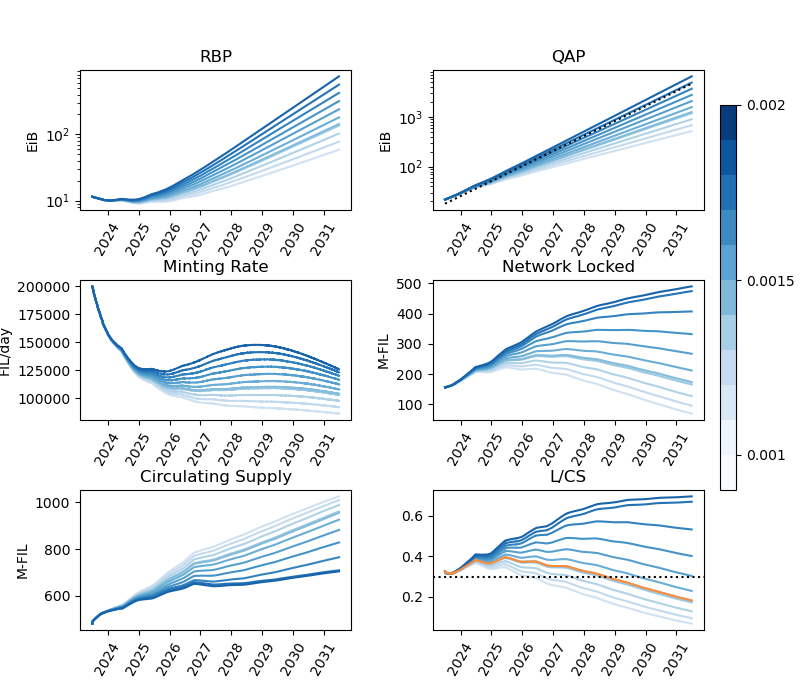

In [36]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,7))

cmap_access_vec = np.linspace(0.2, 0.8, len(scenario2results))
c_vec = [colors[0](cmap_access_vec[ii]) for ii in range(len(scenario2results))]

axx = ax[0,0]
plot_x(axx, scenario2results, 'rb_total_power_eib', keys, c_vec)
axx.set_yscale('log')
axx.set_ylabel('EiB')
axx.set_title('RBP')
# axx.legend()

axx = ax[0,1]
plot_x(axx, scenario2results, 'qa_total_power_eib', keys, c_vec)
axx.plot(t, baseline, color='k', linestyle=':', label='Baseline')
axx.set_yscale('log')
axx.set_ylabel('EiB')
axx.set_title('QAP')

axx = ax[1,0]
plot_x(axx, scenario2results, 'day_network_reward', keys, c_vec)
axx.set_ylabel('FIL/day')
axx.set_title('Minting Rate')

axx = ax[1,1]
plot_x(axx, scenario2results, 'network_locked', keys, c_vec, scale_by=1e6)
axx.set_ylabel('M-FIL')
axx.set_title('Network Locked')
# axx.axhline(0, linestyle=':', color='k', linewidth=2)

axx = ax[2,0]
plot_x(axx, scenario2results, 'circ_supply', keys, c_vec, scale_by=1e6)
axx.set_ylabel('M-FIL')
axx.set_title('Circulating Supply')

axx = ax[2,1]
for ii, scenario in enumerate(keys):
    res = scenario2results[scenario]
    axx.plot(t, res['network_locked']/res['circ_supply'], label=keys[ii], color=c_vec[ii])
# plot the MCMC run in red
res = scenario2results['0.001354']
axx.plot(t, res['network_locked']/res['circ_supply'], label=keys[ii], color=colors[1](0.5))
for tick in axx.get_xticklabels():
    tick.set_rotation(60)
axx.set_title('L/CS')
axx.axhline(0.3, color='k', linestyle=':')

divider = make_axes_locatable(axx)
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.88,
                    wspace=0.3, hspace=0.5)

cbar_ax = fig.add_axes([0.9, 0.30, 0.02, 0.55])
# cax = divider.append_axes('right', size='5%', pad=0.05)
vmin = 0.001
vmax = 0.002
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colors[0], norm=norm)
delta = 0.0001
sm.set_array([])
cbar = fig.colorbar(sm, ticks=[0.001, 0.0015, 0.002], 
                    boundaries=np.arange(vmin-delta,vmax+delta,delta),
                    cax=cbar_ax,
                    label='g')
cbar.ax.set_yticklabels(['0.001', '0.0015', '0.002']) 

# plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'locked_trajectories.png'))